In [6]:
import sys
sys.path.append("..")
import os

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_orig()


In [7]:
from coda.utils.postprocessing import (
    load_data_assimilation_network, 
    load_hydra_config,
    reconstruct_observations,
)
from coda.datamodule.DataLoader import L96InferenceDataset
from coda.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [8]:
baseline_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/baseline_data_assimilation_l96_one_level"
experiment_dir = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
ground_truths = []
observations = []
mask = []
analysis_enks = []
analysis_oi = []

files = os.listdir(baseline_dir)
files = [file for file in files if file.endswith(".npy")]
for file in files:
    baseline = np.load(os.path.join(baseline_dir, file), allow_pickle=True).item()
    ground_truths.append(baseline["simulation"])
    observations.append(baseline["observations"])
    the_mask = observations[-1] == 0
    mask.append(the_mask)
    analysis_enks.append(baseline["enks_perturb_obs"])
    analysis_oi.append(baseline["optimal_interpolation"])

ground_truths = torch.tensor(np.stack(ground_truths)).float()
observations = torch.tensor(np.stack(observations)).float()
mask = torch.logical_not(torch.tensor(np.stack(mask))).float()
analysis_enks = torch.tensor(np.stack(analysis_enks)).float()
analysis_oi = torch.tensor(np.stack(analysis_oi)).float()

In [10]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [11]:
# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
)

# instantiate dataset
dataset = L96InferenceDataset(
    ground_truth_data=ground_truths,
    observation_model=observational_model,
    observations=observations,
    mask=mask,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=False,
)
print(f"Number of samples: {len(dataset)}")

Number of samples: 1101


In [12]:
analysis = reconstruct_observations(dataset, assimilation_network)

In [13]:
initial_state_oi = analysis_oi[:, 625]
initial_state_enks = analysis_enks[:, 625]
initial_state_nn = analysis[:, 625]
initial_state_true = ground_truths[:, 625]

forward_operator = L96Simulator(forcing=8.0)
time = torch.arange(0, 200*0.01, 0.01)
forecast_oi = forward_operator.integrate(time=time, state=initial_state_oi).squeeze()
forecast_enks = forward_operator.integrate(time=time, state=initial_state_enks).squeeze()
forecast_nn = forward_operator.integrate(time=time, state=initial_state_nn).squeeze()

In [14]:
error_analysis_oi = analysis_oi[:, 25:625] - ground_truths[:, 25:625]
error_analysis_enks = analysis_enks[:, 25:625] - ground_truths[:, 25:625]
error_analysis_nn = analysis[:, 25:625] - ground_truths[:, 25:625]

In [15]:
def rmse_per_batch(prediction, truth):
    squered_errors = (prediction.cpu() - truth.cpu())**2
    mean_errors = squered_errors.mean((-1, 0)).sqrt()
    std_errors = squered_errors.mean((-1)).sqrt().std((0))
    return mean_errors, std_errors

In [16]:
true = ground_truths[:, 625:825]
mean_error_oi, std_error_oi = rmse_per_batch(true, forecast_oi)
mean_error_enks, std_error_enks = rmse_per_batch(true, forecast_enks)
mean_error_nn, std_error_nn = rmse_per_batch(true, forecast_nn)

In [17]:
analysis_time_labels = torch.arange(0, 601*0.01, 0.01)
forecast_time_labels = torch.arange(600*0.01, 800*0.01, 0.01)
location_labels = torch.arange(0, 40, 1)

In [18]:
limit_array = torch.stack([ground_truths[0, 25:625], observations[0, 25:625], analysis_oi[0, 25:625], analysis_enks[0, 25:625], analysis[0, 25:625]])
vmin = np.nanmin(limit_array)
vmax = np.nanmax(limit_array)

/tmp/ipykernel_144150/4061553601.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(img_b, ax=axd["b"])


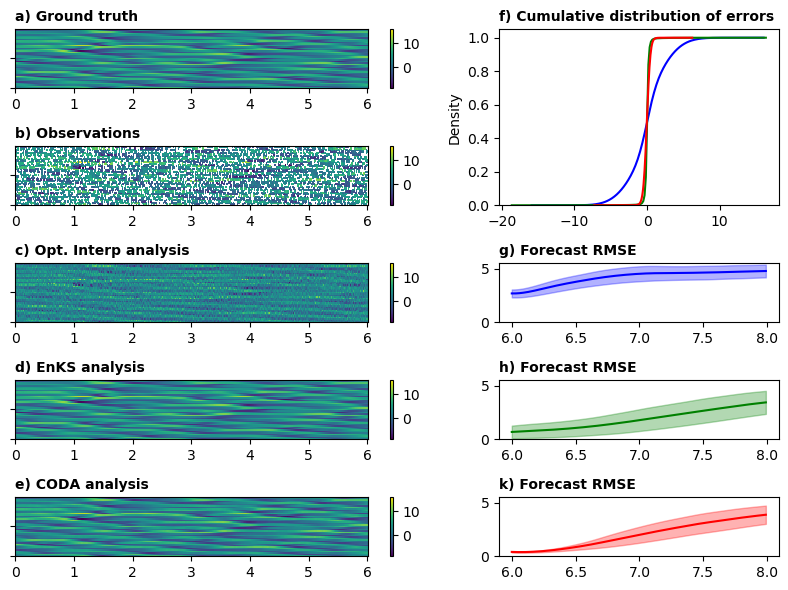

In [19]:
mosaic = """
aaaff
bbbff
cccgg
dddhh
eeekk
"""

fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 6))

img_a = axd["a"].pcolor(analysis_time_labels, location_labels, ground_truths[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_a, ax=axd["a"])
observations_view = observations[0, 25:626]
mask_bool = torch.logical_not(mask[0, 25:626].bool())
observations_view[mask_bool] = np.nan
img_b = axd["b"].pcolor(analysis_time_labels, location_labels,observations_view.T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_b, ax=axd["b"])

img_c = axd["c"].pcolor(analysis_time_labels, location_labels,analysis_oi[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_c, ax=axd["c"])
img_d = axd["d"].pcolor(analysis_time_labels, location_labels,analysis_enks[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_d, ax=axd["d"])
img_e = axd["e"].pcolor(analysis_time_labels, location_labels,analysis[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_e, ax=axd["e"])

sns.kdeplot(error_analysis_oi.flatten(), color='blue', ax=axd["f"], label='Opt. Interp.', cumulative=True)
sns.kdeplot(error_analysis_enks.flatten(), color='green', ax=axd["f"], label='Enks', cumulative=True)
sns.kdeplot(error_analysis_nn.flatten(), color='red', ax=axd["f"], label='NN', cumulative=True)

axd["g"].plot(forecast_time_labels, mean_error_oi, color="blue")
axd["g"].fill_between(forecast_time_labels, mean_error_oi-std_error_oi, mean_error_oi+std_error_oi, color="blue", alpha=0.3)
axd["g"].set_ylim(0, 5.5)
axd["h"].plot(forecast_time_labels, mean_error_enks, color="green")
axd["h"].fill_between(forecast_time_labels, mean_error_enks-std_error_enks, mean_error_enks+std_error_enks, color="green", alpha=0.3)
axd["h"].set_ylim(0, 5.5)
axd["k"].plot(forecast_time_labels, mean_error_nn, color="red")
axd["k"].fill_between(forecast_time_labels, mean_error_nn-std_error_nn, mean_error_nn+std_error_nn, color="red", alpha=0.3)
axd["k"].set_ylim(0, 5.5)

for letter, ax in axd.items():
    title = f"{letter}) "
    if letter == "a": title += "Ground truth"
    if letter == "b": title += "Observations"
    if letter == "c": title += "Opt. Interp analysis"
    if letter == "d": title += "EnKS analysis"
    if letter == "e": title += "CODA analysis"
    if letter == "f": title += "Cumulative distribution of errors"
    if letter in ["g", "h", "k"]: title += "Forecast RMSE"
    ax.set_title(title, loc="left", fontsize=10, fontweight="bold")
    
    if letter in ["a", "b", "c", "d", "e"]:
        ax.set_yticklabels([])

plt.tight_layout()
plt.savefig("fig_3.png", dpi=300)